# 기본 그래프 생성

이번 튜토리얼에서는 LangGraph를 사용하여 그래프를 생성하는 방법을 배웁니다.

LangGraph 의 그래프를 정의하기 위해서는

1. State 정의
2. 노드 정의
3. 그래프 정의
4. 그래프 컴파일
5. 그래프 시각화

단계를 거칩니다.

그래프 생성시 조건부 엣지를 사용하는 방법과 다양한 흐름 변경 방법을 알아봅니다.

![langgraph-building-graphs](assets/langgraph-building-graphs.png)

## State 정의

In [1]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator


# State 정의
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]

## 노드 정의

In [5]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve: 검색
    documents = "검색된 문서 (retrieve)"
    return {"context": documents}


def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform: 쿼리 재작성
    documents = "검색된 문서 (rewrite_query)"
    return GraphState(context=documents)


def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM 실행
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)


def llm_claude_execute(state: GraphState) -> GraphState:
    # LLM 실행
    answer = "Claude 의 생성된 답변"
    return GraphState(answer=answer)


def relevance_check(state: GraphState) -> GraphState:
    # Relevance Check: 관련성 확인
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score)


def sum_up(state: GraphState) -> GraphState:
    # sum_up: 결과 종합
    answer = "종합된 답변"
    return GraphState(answer=answer)


def search_on_web(state: GraphState) -> GraphState:
    # Search on Web: 웹 검색
    documents = state["context"] = "기존 문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)


def get_table_info(state: GraphState) -> GraphState:
    # Get Table Info: 테이블 정보 가져오기
    table_info = "테이블 정보"
    return GraphState(context=table_info)


def generate_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query: SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)


def execute_sql_query(state: GraphState) -> GraphState:
    # Execute SQL Query: SQL 쿼리 실행
    sql_result = "SQL 결과"
    return GraphState(context=sql_result)


def validate_sql_query(state: GraphState) -> GraphState:
    # Validate SQL Query: SQL 쿼리 검증
    binary_score = "SQL 쿼리 검증 결과"
    return GraphState(binary_score=binary_score)


def handle_error(state: GraphState) -> GraphState:
    # Error Handling: 에러 처리
    error = "에러 발생"
    return GraphState(context=error)


def decision(state: GraphState) -> GraphState:
    # 의사결정
    decision = "결정"
    # 로직을 추가할 수 가 있고요.

    if state["binary_score"] == "yes":
        return "종료"
    else:
        return "재검색"

## 그래프 정의

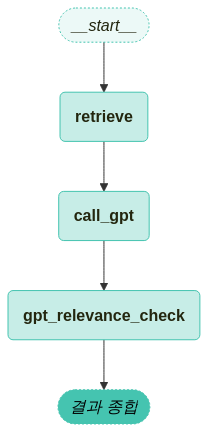

In [19]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

# (1): Conventional RAG
# (2): 재검색
# (3): 멀티 LLM
# (4): 쿼리 재작성


# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가합니다.
workflow.add_node("retrieve", retrieve)

# workflow.add_node("rewrite_query", rewrite_query)  # (4)

workflow.add_node("call_gpt", llm_gpt_execute)
# workflow.add_node("call_claude", llm_claude_execute)  # (3)
workflow.add_node("gpt_relevance_check", relevance_check)
# workflow.add_node("claude_relevance_check", relevance_check)  # (3)
workflow.add_node("결과 종합", sum_up)

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "call_gpt")
# workflow.add_edge("retrieve", "call_claude")  # (3)
# workflow.add_edge("rewrite_query", "retrieve")  # (4)
workflow.add_edge("call_gpt", "gpt_relevance_check")
workflow.add_edge("gpt_relevance_check", "결과 종합")
# workflow.add_edge("call_claude", "claude_relevance_check")  # (3)
# workflow.add_edge("claude_relevance_check", "결과 종합")  # (3)

workflow.add_edge("결과 종합", END)  # (2) - off

# 조건부 엣지를 추가합니다. (2), (4)
# workflow.add_conditional_edges(
#     "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     decision,
#     {
#         "재검색": "retrieve",  # 관련성이 있으면 종료합니다.
#         "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
#     },
# )

# 조건부 엣지를 추가합니다. (4)
# workflow.add_conditional_edges(
#     "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     decision,
#     {
#         "재검색": "rewrite_query",  # 관련성이 있으면 종료합니다.
#         "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
#     },
# )

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

## SQL RAG

In [20]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가합니다.
workflow.add_node("질문", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("call_gpt", llm_gpt_execute)
workflow.add_node("gpt_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# 각 노드들을 연결합니다.
workflow.add_edge("질문", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",
    decision,
    {
        "QUERY ERROR": "rewrite_query",
        "UNKNOWN MEANING": "rewrite_question",
        "PASS": "call_gpt",
    },
)

workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("call_gpt", "gpt_relevance_check")
workflow.add_edge("gpt_relevance_check", "결과 종합")
workflow.add_edge("결과 종합", END)

# 시작점을 설정합니다.
workflow.set_entry_point("질문")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

그래프를 시각화 합니다.

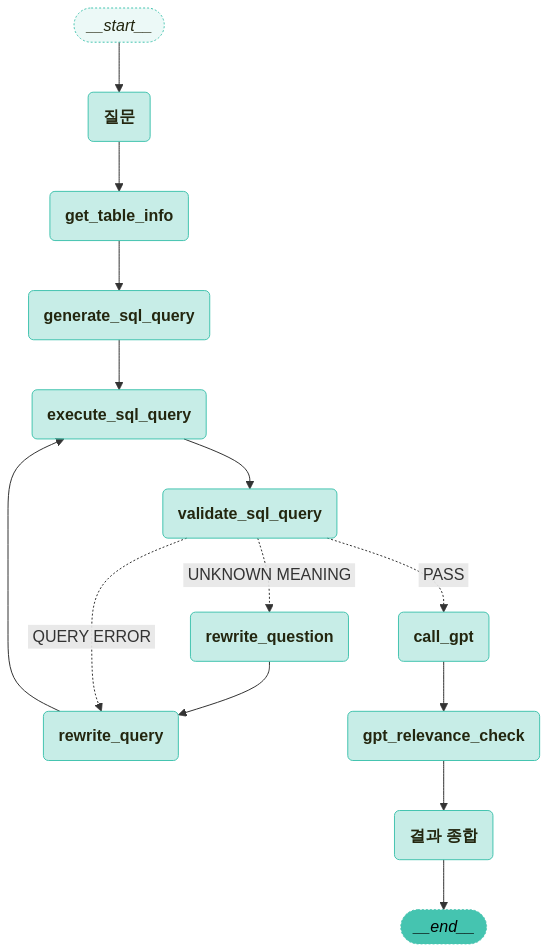

In [21]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)